# Figure Creation Notebook

-------------------

## 1. Task Type Analysis

Conducting analysis on the difference in performance between CoT and Direct Answering by task type (extraction, clf, gen).

Further, deeper analysis is conducted by examining the specific tasks that CoT does worse/better on, and finding patterns between these
tasks to draw conclusions on the performance and effectiveness of CoT within the medical domain.

____

#### Compute Average Performance Increase by Task Type

In [21]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import sys

def load_sheet(sheet_path):
    '''
    Input: path to excel sheet
    Output: pandas dataframe of entire excel spreadsheet
    '''
    sheet = pd.ExcelFile(sheet_path)

    return sheet


def get_performances(google_sheet, task_type, sheet_name):
    '''
    Given the name of the sheet (3 total), get all the performances
    for the tasks that have that task type
    '''

    # Maps task_name: [list of all relative differences in performance]
    task_performances = {}

    # Load the specific sheet
    data = google_sheet.parse(sheet_name)
    for row_idx, tt in enumerate(data["Task Type"]):

        # If task type of this task matches the desired task type
        if tt == task_type:
            task_name = data["Task Name"][row_idx]
            task_performance = data["Relative Difference"][row_idx]

            if task_name not in task_performances:
                task_performances[task_name] = []

            task_performances[task_name].append(task_performance)

    # Averaging Step
    for key in task_performances:
        task_performances[key] = round(sum(task_performances[key]) / len(task_performances[key]) * 100, 2)

    return task_performances


# Will need to call this function once for each task type (Text Classification, Normalization, etc..)

sheet_path = "/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/CoT-Difference-Sheet.xlsx"

google_sheet = load_sheet(sheet_path)


#### Classification Tasks

_____

In [22]:
text_classification = get_performances(google_sheet, "Text Classification", 'CLF-Difference')
nli = get_performances(google_sheet, "Natural Language Inference", 'CLF-Difference')
normalization = get_performances(google_sheet, "Normalization and Coding", 'CLF-Difference')
similarity = get_performances(google_sheet, "Semantic Similarity", 'CLF-Difference')

#### Extraction Tasks 

_____

In [23]:
event_extraction = get_performances(google_sheet, "Event Extraction", 'EXT-Difference')
named_entity_recognition = get_performances(google_sheet, "Named Entity Recognition", 'EXT-Difference')
ext_normalization = get_performances(google_sheet, "Normalization and Coding", 'EXT-Difference')

#### Generation Tasks

___

In [24]:
question_answering = get_performances(google_sheet, "Question Answering", 'Gen-Difference')
summarization = get_performances(google_sheet, "Summarization", 'Gen-Difference')

In [25]:
def combine_dicts(dicts):
    '''
    Given a list of dictionaries, combine them into one dictionary
    '''
    combined = {}
    for d in dicts:
        for key, value in d.items():
            # skip outlier
            if key in {"CARES-ICD10 Chapter", "n2c2 2014-Hyperlipidemia", "n2c2 2010-Relation", "n2c2 2010-Assertion", "Medication extraction"}:
                continue
            if key not in combined:
                combined[key] = value
            else:
                combined[key] += value

    return combined

# Combine all dictionaries into one
combined = combine_dicts([text_classification, nli, normalization, similarity, event_extraction, named_entity_recognition, ext_normalization, question_answering, summarization])

[0.43348043 0.87949223 0.97095506 0.69636278 0.01815361 0.8636222
 0.84723133 0.71678193 0.35640262 0.20327193 0.98903838 0.58280774
 0.23525082 0.50324712 0.1699635  0.8688575  0.56225292 0.84879581
 0.18552053 0.73909911 0.6316736  0.07326809 0.29613152 0.32993735
 0.37950108 0.37389527 0.19609985 0.33096658 0.99038343 0.13633373
 0.06703807 0.45039538 0.68985593 0.05404399 0.21466772 0.7794637
 0.61294613 0.1539416  0.11921476 0.57598537 0.00210673 0.91383285
 0.86506189 0.47098545 0.10760921 0.99291874 0.52361179 0.08633622
 0.64584887 0.16351843 0.91677115 0.87991823 0.04203534 0.04859454
 0.39708609 0.31021997 0.96562711 0.08750967 0.42587689 0.75865503
 0.93414016 0.63191343 0.70360418 0.02901954 0.43054314 0.36593106
 0.79911303 0.86995449 0.10655281 0.2167537  0.90808439 0.38770178
 0.02706086 0.64678978 0.69197844 0.71492246 0.59128683 0.04774062
 0.92471664 0.83888021 0.55420111 0.53481319]


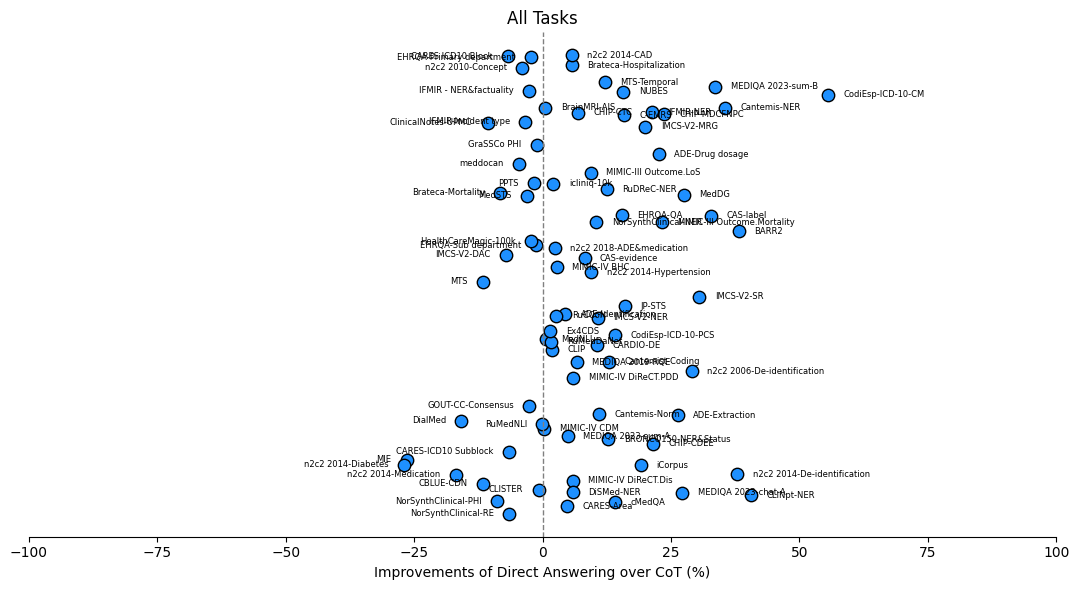

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_task_numberline(task_improvements, title="Task Improvements Numberline"):
    """
    Plots a numberline scatter plot for task improvements, with a taller figure
    and text labels placed horizontally next to each data point.

    Parameters:
        task_improvements (dict): Dictionary mapping task names to their average improvement (%)
        title (str): Title of the plot.
    """
    # Extract task names and improvements
    tasks = list(task_improvements.keys())
    improvements = [task_improvements[task] for task in tasks]
    
    # Create small jitter for y-values to reduce marker overlap
    y_jitter = np.random.uniform(0, 1, len(tasks))
    print(y_jitter)
    # y_jitter = 0
    
    # Create the figure with an increased vertical size (e.g., height=6 inches)
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the scatter points
    ax.scatter(improvements, y_jitter, color='dodgerblue', s=80, edgecolor='black')
    
    # Draw a vertical baseline at x=0
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    # Remove the top, right, and left spines (keeping a clean numberline at the bottom)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Remove y-axis ticks
    ax.set_yticks([])
    
    # Place the task name next to each point:
    # For positive improvements, place the label to the right; for negatives, to the left.
    for i, task in enumerate(tasks):
        if improvements[i] >= 0:
            ax.text(improvements[i] + 3, y_jitter[i], task,
                    ha='left', va='center', fontsize=6, rotation=0)
        else:
            ax.text(improvements[i] - 3, y_jitter[i], task,
                    ha='right', va='center', fontsize=6, rotation=0)
    
    # Set label and title
    ax.set_xlabel("Improvements of Direct Answering over CoT (%)")
    ax.set_title(title)
    ax.xaxis.set_ticks_position('bottom')
    
    plt.tight_layout()
    ax.set_xlim(-100, 100)
    # ax.set_ylim(-0.1, 1.5)
    plt.show()

plot_task_numberline(combined, title="All Tasks")



#### Task Statistics

___


In [27]:
def get_statistics(performance_values):
    """
    Given a list of all performance values, return 
    all descriptive statistics
        - mean, std, median
    """

    mean = np.mean(performance_values)

    std = np.std(performance_values)

    median = np.median(performance_values)

    return mean, std, median

all_task_performances = list(combined.values())

mean, std, median = get_statistics(all_task_performances)

print(mean, std, median)


count = 0
for val in all_task_performances:
    if val >= 0:
        count += 1

print(count, len(all_task_performances))


8.020853658536584 15.202315468793905 5.8149999999999995
56 82


#### Get the tasks that performed worse/better

____

In [28]:
cot_better = []
da_better = []

for task, metric in combined.items():
    if metric >=0:
        da_better.append(task)

    else:
        cot_better.append(task)


# print(len(da_better))

_____

## 2. Model Analysis

Previously, we examined the effect of the TASK TYPE on the performance of CoT prompting vs. Direct Answering.

In this section, we will explore how the performances of CoT vs. Direct Answering varies across different models.
- Want to keep the tasks constant
- Model is the independent variable. Calculate the average performance for each model across ALL tasks!

____

In [52]:
# sheet_path = "/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/CoT-Difference-Sheet.xlsx"
sheet_path = "/Users/kevinxie/Desktop/LLM CoT/LLM-CoT/CoT-Difference-Sheet.xlsx"
google_sheet = load_sheet(sheet_path)

def get_model_performances(google_sheet, sheet_name):
    '''
    Inputs:
        - google_sheet: loaded google sheet (entire .xlsx file)
        - sheet_name: name of the sheet you want to load
    
    Output:
        - model_performances: Dictionary mapping { model name : list of all task performances (relative difference) with that model}
    '''

    model_performances = {}

    data = google_sheet.parse(sheet_name)

    for row, model in enumerate(data["Model Name"]):

        if model not in model_performances:
            model_performances[model] = []

        model_performances[model].append(data["Difference"][row])

    return model_performances        


In [53]:
clf_model_performances = get_model_performances(google_sheet, 'CLF-Difference')
ext_model_performances = get_model_performances(google_sheet, 'EXT-Difference')
gen_model_performances = get_model_performances(google_sheet, 'Gen-Difference')

## Analysis with Model Performances

After extracting all the data for the model performances, we will conduct analysis on the differences. Specifically, we can examine:
- Improvements in average model performance by task type (CLF, EXT, GEN)
- General improvements in model performance overall (combining all task types)
- Even further analysis by domain, model size, reasoning vs non-reasoning, etc. (see docs and email)

____

#### 2.1: Average Model Performance by Task Type

{'Baichuan-M1-14B-Instruct': [2.62, -4.22, 11.73, -20.96, -1.02, -13.36, -5.86, 0.42, -0.1, 5.23, -7.43, 0.44, 6.49, 2.05, 0.18, 0.62, 3.92, 13.94, -4.99, -0.82, -10.0, 10.73, 1.48, 1.14, 1.72, 15.95, -4.24, 1.54, -2.81, 0.9, -3.38, -3.54, 11.03, -0.25, -1.97, 8.92, 18.06, 5.29, 6.59, 1.74, 4.48, 7.2, 0.0, 7.4, -0.34, -8.82, 5.41, 14.88, -0.05, 11.55, 0.99, -0.16, 7.76, 2.48, 3.13, 14.94, 0.16, 3.47, 2.6, -0.36, 4.2, 19.6, -1.48, -1.44, -0.39, 0.49, -2.24, 2.24, -1.58, -11.46, 1.75, 6.79, 1.11, -15.61, 2.12, 6.0, 1.66, 0.65, -0.03, 6.06, 6.28, 6.98, -1.71, 0.08, -3.28, -4.37, 2.62], 'DeepSeek-R1': [-0.72, -0.36, 1.56, -3.37, -0.03, 1.39, 0.22, 0.05, 0.11, 1.6, -1.72, 1.16, -0.94, 1.19, 0.02, 0.4, -1.13, 1.81, 0.03, 1.95, -0.47, 6.61, -1.55, 0.0, 1.86, 1.27, -1.93, 2.39, 0.72, 0.77, -2.82, -1.83, -3.94, -2.68, -1.39, 11.93, 8.8, 20.23, 3.49, -0.05, 2.21, 11.94, 1.63, 1.31, 2.71, -3.2, -0.94, 0.74, 0.4, 0.4, 5.02, 1.17, 4.48, 0.69, -2.05, 0.61, 1.38, -0.45, -0.97, 12.24, 1.86, 13.41, 6.9

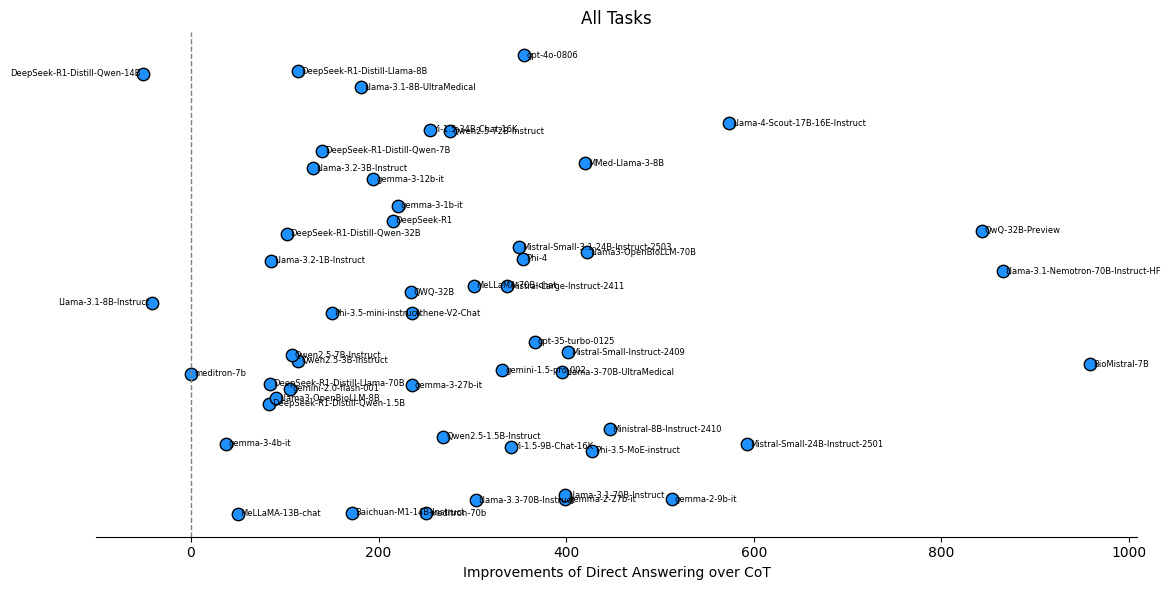

In [60]:
def plot_model_numberline(model_improvements, title="Task Improvements Numberline"):
    """
    Plots a numberline scatter plot for task improvements, with a taller figure
    and text labels placed horizontally next to each data point.

    Parameters:
        model_improvements (dict): Dictionary mapping task names to their LIST of performances
        title (str): Title of the plot.
    """
    # model_improvements = model_improvements.copy()

    # Average all performances
    for model in model_improvements:
        model_improvements[model] = round(sum(model_improvements[model]) / len(model_improvements[model]) * 100, 2)

    # Extract task names and improvements
    tasks = list(model_improvements.keys())
    improvements = [model_improvements[task] for task in tasks]
    
    # Create small jitter for y-values to reduce marker overlap
    y_jitter = np.random.uniform(0, 1, len(tasks))
    
    # Create the figure with an increased vertical size (e.g., height=6 inches)
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the scatter points
    ax.scatter(improvements, y_jitter, color='dodgerblue', s=80, edgecolor='black')
    
    # Draw a vertical baseline at x=0
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    # Remove the top, right, and left spines (keeping a clean numberline at the bottom)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Remove y-axis ticks
    ax.set_yticks([])
    
    # Place the task name next to each point:
    # For positive improvements, place the label to the right; for negatives, to the left.
    for i, task in enumerate(tasks):
        if improvements[i] >= 0:
            ax.text(improvements[i] + 3, y_jitter[i], task,
                    ha='left', va='center', fontsize=6, rotation=0)
        else:
            ax.text(improvements[i] - 3, y_jitter[i], task,
                    ha='right', va='center', fontsize=6, rotation=0)
    
    # Set label and title
    ax.set_xlabel("Improvements of Direct Answering over CoT")
    ax.set_title(title)
    ax.xaxis.set_ticks_position('bottom')
    
    plt.tight_layout()
    # ax.set_xlim(-100, 100)
    # ax.set_ylim(-0.1, 1.5)
    plt.show()


print(clf_model_performances)
combined = {}

clf_model_performances = get_model_performances(google_sheet, 'CLF-Difference')
ext_model_performances = get_model_performances(google_sheet, 'EXT-Difference')
gen_model_performances = get_model_performances(google_sheet, 'Gen-Difference')

for model in clf_model_performances:
    combined[model] = clf_model_performances[model]
    combined[model].extend(ext_model_performances[model])
    combined[model].extend(gen_model_performances[model])

plot_model_numberline(combined, title="All Tasks")




# count = 0
# for performance in gen_model_performances:
#     if float(gen_model_performances[performance]) >= 0:
#         count += 1

#     else:
#         print(performance, gen_model_performances[performance])



there is probably something wrong with the data file itself...